In [ ]:
!pip install transformers datasets evaluate

In [ ]:
import pandas as pd
import re
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from peft import LoraConfig, get_peft_model, TaskType

# Project :



This notebook was created to fine-tune a pre-trained model for named entity recognition in English.

The data comes from news articles published in October 2025. The articles were downloaded from the Europresse platform.

The articles were first annotated using the ```english_web_core_trf``` pipeline from spaCy. The annotation were then corrected by 4 annotators, and exported in a .csv file to be used as data to fine-tune the model.

Pre-trained model that was fine-tuned : https://huggingface.co/distilbert/distilbert-base-uncased

The model is then evaluated using a confusion matrix. The results are very encouraging.
<br></br>
*Please note that much of the code used here is either inspired by or directly taken from Ms. Delphine Bernhard's Machine Learning course given at the Université de Strasbourg.*
___

# Data retrieval and formatting

In [ ]:
# load data
dataset = Dataset.from_csv("/content/correction_annotation - corpus_anno_no_text.csv")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['index', 'expression', 'tag', 'correction', 'Erreur', 'correction_finale'],
    num_rows: 6607
})

In [ ]:
# check values to discard
dataset.unique("correction_finale")

['ORG',
 'PRODUCT',
 'PERSON',
 'GPE',
 None,
 'NORP',
 'EVENT',
 'FAC',
 'LOC',
 ' NULL']

In [ ]:
# withdraw anotations that were labeled as wrong
dataset = dataset.filter(lambda x: (
    x["correction_finale"] is not None
    and x["correction_finale"] != " NULL")
)

Filter:   0%|          | 0/6607 [00:00<?, ? examples/s]

In [ ]:
# keep only useful columns
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["expression", "correction_finale"]])
dataset

Dataset({
    features: ['expression', 'correction_finale'],
    num_rows: 5963
})

In [ ]:
# set of tags
tags = set(dataset['correction_finale'])
# encode labels as ClassLabel
dataset = dataset.cast_column("correction_finale", ClassLabel(names=list(tags)))
dataset = dataset.rename_column("correction_finale", "label")

Casting the dataset:   0%|          | 0/5963 [00:00<?, ? examples/s]

In [ ]:
# target classes
target_classes = dataset.features['label'].names
target_classes

['PERSON', 'GPE', 'ORG', 'FAC', 'EVENT', 'PRODUCT', 'LOC', 'NORP']

In [ ]:
# numerical IDs for classes
[dataset.features['label'].str2int(c) for c in target_classes]

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# link between numerical classes and semantic classes
label2id = {target_classes[i]:i for i in range(len(target_classes))}
id2label = {i:target_classes[i] for i in range(len(target_classes))}

In [ ]:
# first train/test split
# shuffle because data is currenlty in chronological order
dataset = dataset.train_test_split(test_size = 0.2, shuffle=True, seed=47)
# second split to get a validation set as well
dataset2 = dataset["test"].train_test_split(test_size = 0.5, shuffle=True, seed = 47)
# DatasetDict that contains all splitted data
ds = DatasetDict({
    "train": dataset["train"],
    "validation": dataset2["train"],
    "test": dataset2["test"]
})

In [ ]:
# check structure of DatasetDict
ds

DatasetDict({
    train: Dataset({
        features: ['expression', 'label'],
        num_rows: 4770
    })
    validation: Dataset({
        features: ['expression', 'label'],
        num_rows: 596
    })
    test: Dataset({
        features: ['expression', 'label'],
        num_rows: 597
    })
})

In [ ]:
ds['train'].features

{'expression': Value('string'),
 'label': ClassLabel(names=['PERSON', 'GPE', 'ORG', 'FAC', 'EVENT', 'PRODUCT', 'LOC', 'NORP'])}

In [ ]:
ds['train'][0:3]

{'expression': ['manchester', 'eu', 'arteta'], 'label': [1, 1, 0]}

# Tokenization

In [ ]:
model_dBERT = "distilbert/distilbert-base-uncased"
# load model's pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dBERT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# tokenize function
def preprocess_function(dataset):
    return tokenizer(dataset["expression"], padding=True, truncation=True)

In [ ]:
# data tokenization
tokenized_data = ds.map(preprocess_function, batched=True, batch_size=None)

Map:   0%|          | 0/4770 [00:00<?, ? examples/s]

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

# Evaluation settings

In [ ]:
# evaluation metrics
accuracy = evaluate.load('accuracy')
f1_metric = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc['accuracy'], "f1-macro": f1["f1"]}

# Fine-tuning

In [ ]:
# load model
# GPU is used if available, if not CPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_model = AutoModel.from_pretrained(model_dBERT).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
batch_size = 8

# training arguments
training_args = TrainingArguments(
    output_dir=f"{model_dBERT}-finetuned-NER-LoRA",
    fp16=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=1,
    learning_rate=3e-4,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1-macro",
    logging_steps=50,
    report_to="none",
)

# LoRA parameters for fine-tuning process
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8, # avant: 4
    lora_alpha=32, # avant : 16
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]
)

In [ ]:
# dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# early stopping to avoid unnecessary training
early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001
)

def get_model():
    model = AutoModelForSequenceClassification.from_pretrained(
    model_dBERT, num_labels=len(target_classes), id2label=id2label, label2id=label2id
    ).to(device)
    lora_model = get_peft_model(model, lora_config)
    return lora_model

def init_trainer():
  model = get_model()
  return Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_data["train"],
      eval_dataset=tokenized_data["validation"],
      tokenizer=tokenizer,
      data_collator=data_collator,
      callbacks=[early_stop],
      compute_metrics=compute_metrics
  ), model

In [ ]:
# initialization of training
trainer, model = init_trainer()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2581050247.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [ ]:
# model fine-tuning
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,0.522800,0.540075,0.843960,0.633366
2,0.431900,0.391466,0.884228,0.774802
3,0.334100,0.398491,0.887584,0.823492
4,0.386200,0.413841,0.887584,0.813782
5,0.233100,0.391526,0.897651,0.823293


TrainOutput(global_step=2985, training_loss=0.4481099945017241, metrics={'train_runtime': 193.5336, 'train_samples_per_second': 246.469, 'train_steps_per_second': 30.847, 'total_flos': 81610825233600.0, 'train_loss': 0.4481099945017241, 'epoch': 5.0})

# Performance analysis

In [ ]:
preds_output = trainer.predict(tokenized_data['validation'])

In [ ]:
preds_output.metrics

{'test_loss': 0.3984913229942322,
 'test_accuracy': 0.8875838926174496,
 'test_f1-macro': 0.8234920287361412,
 'test_runtime': 2.6384,
 'test_samples_per_second': 225.893,
 'test_steps_per_second': 28.426}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = tokenized_data['validation']['label']

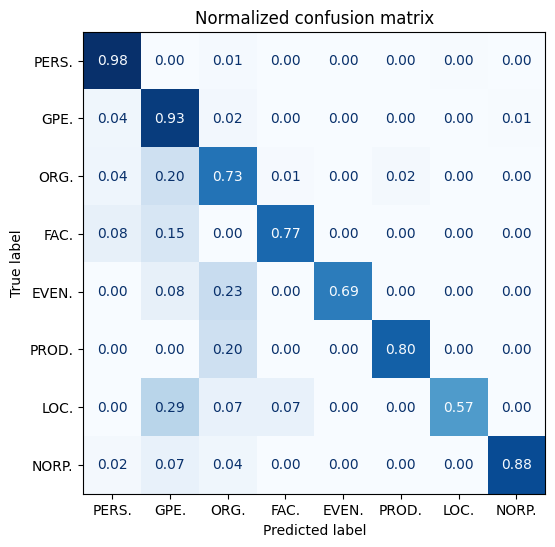

In [ ]:
# generate a confusion matrix to analyze performances qualitatively
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    labels_for_fig = [l[0:4]+'.' for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, target_classes)